# Song lyrics - Part 1: Overview

This is the first of several notebooks examining the song lyrics dataset. This notebook explores some basic properties of the dataset, while also tidying up the data for analysis in the following notebooks.

### Imports

In [1]:
import re
import sys
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)
from nltk.corpus import words as nltk_words
from scipy.stats import linregress

from adjustText import adjust_text


sys.path.append('../scripts/')

from nlp import tokenize

### Data

The dataset used here is the table of artist/album/song info and lyrics for every song in the core dataset.

In [2]:
df = pd.read_csv('../songs.csv', low_memory=False)
df = df[~df.song_darklyrics.isnull()]
df = df[df.song_darklyrics.str.strip().apply(len) > 0]
print(df.columns)

Index(['band_name', 'band_id', 'band_url', 'band_country_of_origin',
       'band_location', 'band_status', 'band_formed_in', 'band_genre',
       'band_lyrical_themes', 'band_last_label', 'band_years_active',
       'album_name', 'album_type', 'album_year', 'album_review_num',
       'album_review_avg', 'album_url', 'album_reviews_url', 'song_name',
       'song_length', 'song_url', 'song_darklyrics', 'song_darklyrics_url',
       'band_current_label'],
      dtype='object')


### Cleanup song lyrics

There were some issues when parsing lyrics. They are handled here since it isn't quite worth it to rescrape all of darklyrics again with a new scraper.

In [3]:
print('Number of songs', len(df))

Number of songs 60964


In [4]:
# Remove songs that are mostly non-English

min_english = 0.6  # A little higher than 50% to include songs with translations, whose lyrics typically include original and translated text

rows = []
song_words = []
for i, row in df.iterrows():
    text = row.song_darklyrics.strip()
    words = tokenize(text)
    english_words = tokenize(text, english_only=True)
    is_english = len(english_words) > min_english * len(words)
    if is_english:
        rows.append(row)
        song_words.append(english_words)
print('Non-English songs removed: ', len(df) - len(rows))
df = pd.DataFrame(rows, columns=df.columns)
df['song_words'] = song_words

KeyboardInterrupt: 

In [5]:
# Remove songs that were copyright claimed

copyrighted = df.song_darklyrics.str.contains('lyrics were removed due to copyright holder\'s request')
print('Songs with lyrics removed: ', len(df[copyrighted]))
df = df[~copyrighted]

Songs with lyrics removed:  66


### Reduced dataset

For lyrical analyses the data is reduced to just a column of lyrics (which will become the feature vector upon some transformation to a quantitative representation) for each song and columns for the most popular genres (the target/label vectors). These are the genres that appear at least once in isolation, i.e. not accompanied by any other genre, and that appear in some minimum percentage of songs. For example, the "black" metal label can appear on bands with or without other genres, but a label like "atmospheric" never appears on its own despite being fairly popular, usually because it is more of an adjective to denote subgenres like atmospheric black metal; thus "black" is included in the reduced label space but "atmospheric" is not. This reduces the genres to a more manageable set: five genres if the minimum occurrence requirement is set to 10%, and thirteen if set to 1%.

A five-genre set would be easier to handle but leaves quite a few holes in the label space, because doom metal, metalcore, folk metal, and many other fairly popular genres are being omitted that may not be covered by any of the five labels. The larger label set covers just about all the most important genres, but because eight of them occur in fewer than 10% of all songs, they will force greater class imbalance which will adversely affect attempts at applying binary classification models later on. For the sake of comparison, both reduced datasets are saved here, but the rest of this exploratory analysis only looks at the 1% dataset, while the 10% dataset is reserved for modeling. Each dataset is saved in its raw form and in a truncated (ML-ready) form containing only the lyrics and genre columns.

In [6]:
def process_genre(genre):
    # Find words (including hyphenated words) not in parentheses
    out = re.findall('[\w\-]+(?![^(]*\))', genre.lower())
    out = [s for s in out if s != 'metal']
    return out


song_genres = df.band_genre.apply(process_genre)
genres = sorted(set(song_genres.sum()))
genre_cols = [f'genre_{genre}' for genre in genres]
for genre, col in zip(genres, genre_cols):
    df[col] = song_genres.apply(lambda x: int(genre in x))

In [7]:
def get_top_genres(data, min_pct):
    isolated = (data.sum(axis=1) == 1)
    isolated_cols = sorted(set(data[isolated].idxmax(axis=1)))
    top_cols = [col for col in isolated_cols if data[col][isolated].mean() >= min_pct]
    top_genres = [re.sub(r"^genre\_", "", col) for col in top_cols]
    return top_genres

In [8]:
top_genres_1pct = get_top_genres(df[genre_cols], 0.01)
print(top_genres_1pct)
df_r = df.copy()
drop_cols = [col for col in df.columns if ('genre_' in col) and (re.sub(r"^genre\_", "", col) not in top_genres_1pct)]
df_r.drop(drop_cols, axis=1, inplace=True)

# Only lyrics and genre are relevant for ML later
df_r_ml = pd.DataFrame(index=range(df.shape[0]), columns=['lyrics'] + top_genres_1pct)
df_r_ml['lyrics'] = df['song_darklyrics'].reset_index(drop=True)
df_r_ml[top_genres_1pct] = df[[f"genre_{genre}" for genre in top_genres_1pct]].reset_index(drop=True)

['black', 'death', 'deathcore', 'doom', 'folk', 'gothic', 'grindcore', 'heavy', 'metalcore', 'power', 'progressive', 'symphonic', 'thrash']


In [9]:
top_genres_10pct = get_top_genres(df[genre_cols], 0.1)
print(top_genres_10pct)
df_rr = df.copy()
drop_cols = [col for col in df.columns if ('genre_' in col) and (re.sub(r"^genre\_", "", col) not in top_genres_10pct)]
df_rr.drop(drop_cols, axis=1, inplace=True)

# Only lyrics and genre are relevant for ML later
df_rr_ml = pd.DataFrame(index=range(df.shape[0]), columns=['lyrics'] + top_genres_10pct)
df_rr_ml['lyrics'] = df['song_darklyrics'].reset_index(drop=True)
df_rr_ml[top_genres_10pct] = df[[f"genre_{genre}" for genre in top_genres_10pct]].reset_index(drop=True)

['black', 'death', 'heavy', 'power', 'thrash']


In [2]:
df_r = pd.read_csv('../songs-1pct.csv')
df_r['song_words'] = df_r['song_words'].apply(literal_eval)
top_genres_1pct = [c for c in df_r.columns if 'genre_' in c]

df_rr = pd.read_csv('../songs-10pct.csv')
df_rr['song_words'] = df_rr['song_words'].apply(literal_eval)
top_genres_10pct = [c for c in df_rr.columns if 'genre_' in c]

SyntaxError: invalid syntax (<unknown>, line 1)

# Basic lyrical properties

This section compares looks at word counts and unique word counts, in absolute counts as well as counts per minute, between different songs, albums, bands, and genres. [Part 3](./lyrics2.ipynb) dives much deeper into evaluating lyrical complexity using various lexical diversity measures from the literature.

Song lyrics are tokenized using a custom `tokenize()` function in `nlp.py`.

In [2]:
df_r = pd.read_csv('../songs-1pct.csv')
df_r['song_words'] = df_r['song_words'].str.split()
top_genres_1pct = [c for c in df_r.columns if 'genre_' in c]

df_rr = pd.read_csv('../songs-10pct.csv')
df_rr['song_words'] = df_rr['song_words'].str.split()
top_genres_10pct = [c for c in df_rr.columns if 'genre_' in c]

# Word counts by song

In [3]:
def to_seconds(data):
    """Convert a time string (MM:ss or HH:MM:ss) to seconds
    """
    out = pd.Series(index=data.index, dtype=int)
    for i, x in data.items():
        if isinstance(x, str):
            xs = x.split(':')
            if len(xs) < 3:
                xs = [0] + xs
            seconds = int(xs[0]) * 3600 + int(xs[1]) * 60 + int(xs[2])
        else:
            seconds = 0
        out[i] = seconds
    return out


def get_words_per_second(data):
    out = pd.DataFrame(index=data.index, dtype=float)
    out['words_per_second'] = (data['word_count'] / data['seconds']).round(2)
    out['words_per_second'][out['words_per_second'] == np.inf] = 0
    out['unique_words_per_second'] = (data['unique_word_count'] / data['seconds']).round(2)
    out['unique_words_per_second'][out['unique_words_per_second'] == np.inf] = 0
    return pd.concat([data, out], axis=1)

In [5]:
df_r_songs = df_r[['band_name', 'album_name', 'song_name', 'band_genre', 'song_words', 'song_length']].copy()
df_r_songs = df_r_songs.rename(columns={'band_name': 'band', 'album_name': 'album', 'song_name': 'song', 'band_genre': 'genre', 'song_words': 'words'})
df_r_songs['seconds'] = to_seconds(df_r_songs['song_length'])
df_r_songs = df_r_songs.drop('song_length', axis=1)
df_r_songs['word_count'] = df_r_songs['words'].apply(len)
df_r_songs['unique_word_count'] = df_r_songs['words'].apply(lambda x: len(set(x)))
df_r_songs = get_words_per_second(df_r_songs)

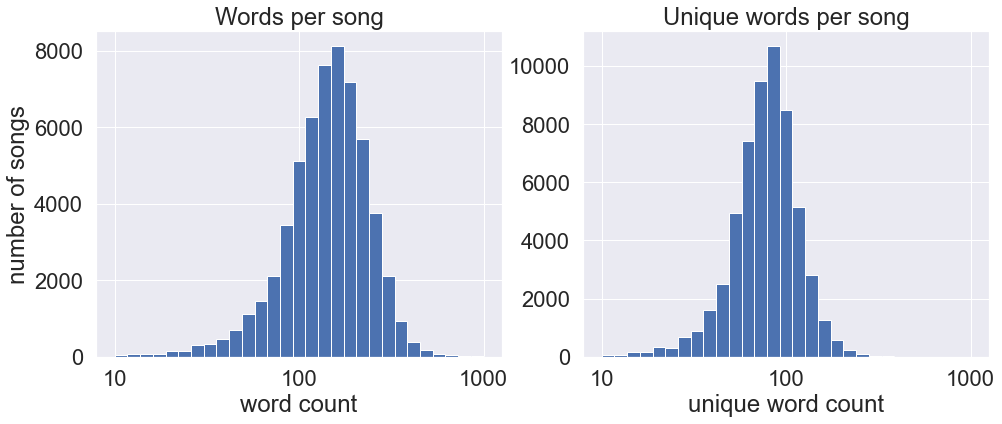

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

df_r_songs['word_count'].hist(bins=np.logspace(1, 3, 30), ax=ax1)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter())
ax1.set_xlabel("word count")
ax1.set_ylabel("number of songs")
ax1.set_title("Words per song")

df_r_songs['unique_word_count'].hist(bins=np.logspace(1, 3, 30), ax=ax2)
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.set_xlabel("unique word count")
ax2.set_title("Unique words per song")

plt.show()

### Songs with highest word counts

The honor of highest word count in a single song goes to the [Bal-Sagoth's "The Obsidian Crown Unbound"](https://youtu.be/xizMG4nI2dk) at over two thousand words. However, most of those words are not sung in the actual song: Bal-Sagoth lyrics typically include the massive collection of narrative text that accompanies their songs. Although the lyrics they sing are still plentiful, there are nowhere near two thousand words spoken in the six-minute symphonic black metal track.

This makes the forty-minute prog metal epic [Crimson by Edge of Sanity](https://youtu.be/St6lJaiHYIc) a better contender for most verbose song. Still, such a claim might be challenged by the fact that the digital edition of the album, which a listener would find on Spotify for instance, divides the single-track album into eight parts. That said, DarkLyrics keeps the original one-track format.

At third place is another multi-part song, [Mirror of Souls](https://youtu.be/y6n1kMsLbc8) by the Christian progressive/power metal group Theocracy. This is less contentious since the official track listing considers this a single track.

In [9]:
song_cols_show = [c for c in df_r_songs.columns if c != 'words']

In [65]:
df_r_songs.sort_values('word_count', ascending=False).reset_index().shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,album,song,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Bal-Sagoth,The Chthonic Chronicles,The Obsidian Crown Unbound,Symphonic/Epic Black Metal,358,2259,897,6.31,2.51
2,Edge of Sanity,Crimson,Crimson,Progressive Death Metal,2400,1948,658,0.81,0.27
3,Theocracy,Mirror of Souls,Mirror of Souls,Epic Progressive Power Metal,1346,1556,457,1.16,0.34
4,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,To Dethrone the Witch-Queen of Mytos K'unn (Th...,Symphonic/Epic Black Metal,405,1306,548,3.22,1.35
5,Bal-Sagoth,The Chthonic Chronicles,Unfettering the Hoary Sentinels of Karnak,Symphonic/Epic Black Metal,262,1237,560,4.72,2.14
6,Bal-Sagoth,Battle Magic,Blood Slakes the Sand at the Circus Maximus,Symphonic/Epic Black Metal,533,1186,530,2.23,0.99
7,Redemption,Redemption,Something Wicked This Way Comes,Progressive Metal,1466,1114,439,0.76,0.3
8,Blind Guardian,A Night at the Opera,And Then There Was Silence,"Speed Metal (early), Power Metal (later)",846,1037,351,1.23,0.41
9,Green Carnation,"Light of Day, Day of Darkness","Light of Day, Day of Darkness",Death Metal (early); Gothic/Progressive Metal/...,3606,1028,318,0.29,0.09
10,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,443,1018,427,2.3,0.96


### Songs with highest unique word counts

In [66]:
df_r_songs.sort_values('unique_word_count', ascending=False).reset_index().shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,album,song,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Bal-Sagoth,The Chthonic Chronicles,The Obsidian Crown Unbound,Symphonic/Epic Black Metal,358,2259,897,6.31,2.51
2,Edge of Sanity,Crimson,Crimson,Progressive Death Metal,2400,1948,658,0.81,0.27
3,Bal-Sagoth,The Chthonic Chronicles,Unfettering the Hoary Sentinels of Karnak,Symphonic/Epic Black Metal,262,1237,560,4.72,2.14
4,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,To Dethrone the Witch-Queen of Mytos K'unn (Th...,Symphonic/Epic Black Metal,405,1306,548,3.22,1.35
5,Bal-Sagoth,Battle Magic,Blood Slakes the Sand at the Circus Maximus,Symphonic/Epic Black Metal,533,1186,530,2.23,0.99
6,Theocracy,Mirror of Souls,Mirror of Souls,Epic Progressive Power Metal,1346,1556,457,1.16,0.34
7,Redemption,Redemption,Something Wicked This Way Comes,Progressive Metal,1466,1114,439,0.76,0.3
8,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,The Splendour of a Thousand Swords Gleaming Be...,Symphonic/Epic Black Metal,363,977,429,2.69,1.18
9,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,443,1018,427,2.3,0.96
10,Bal-Sagoth,The Chthonic Chronicles,Six Score and Ten Oblations to a Malefic Avatar,Symphonic/Epic Black Metal,368,793,415,2.15,1.13


### Songs with highest word density

Again "The Obsidian Crown Unbound" tops the charts for highest number of words per second, however at second place, is ["The Ghosts of Christmas Eve"](https://youtu.be/bT4ruFp5U2w), the two-minute intro track to The Christmas Attic by Trans-Siberian Orchestra. Most of the other tracks on this table are short, typically less than a minute.

In [67]:
df_r_songs.sort_values('words_per_second', ascending=False).reset_index().shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,album,song,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Bal-Sagoth,The Chthonic Chronicles,The Obsidian Crown Unbound,Symphonic/Epic Black Metal,358,2259,897,6.31,2.51
2,Trans-Siberian Orchestra,The Christmas Attic,The Ghosts of Christmas Eve,Orchestral/Progressive Rock/Metal,135,815,311,6.04,2.3
3,Macabre,Gloom,I Need to Kill,Thrash/Death Metal/Grindcore,36,199,77,5.53,2.14
4,Bal-Sagoth,The Chthonic Chronicles,Unfettering the Hoary Sentinels of Karnak,Symphonic/Epic Black Metal,262,1237,560,4.72,2.14
5,Putrid Pile,Paraphiliac Perversions,Toxic Shock Therapy,Brutal Death Metal,4,18,3,4.5,0.75
6,S.O.D.,Bigger than the Devil,Charlie Don't Cheat,Hardcore/Crossover/Thrash Metal,25,105,74,4.2,2.96
7,Napalm Death,Scum,You Suffer,"Hardcore Punk (early), Grindcore/Death Metal (...",1,4,4,4.0,4.0
8,Savatage,The Wake of Magellan,Welcome,"Heavy/Power Metal, Progressive Metal/Rock",131,490,230,3.74,1.76
9,Circle of Dead Children,Human Harvest,White Trash Headache,"Brutal Death Metal, Grindcore",6,21,20,3.5,3.33
10,Suicidal Tendencies,Free Your Soul... and Save My Mind,Cyco Speak,"Thrash Metal/Crossover, Hardcore Punk",183,640,224,3.5,1.22


### Songs with highest unique word density

In [68]:
df_r_songs.sort_values('unique_words_per_second', ascending=False).reset_index().shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,album,song,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Napalm Death,Scum,You Suffer,"Hardcore Punk (early), Grindcore/Death Metal (...",1,4,4,4.0,4.0
2,Wormrot,Dirge,You Suffer but Why Is It My Problem,Grindcore,4,14,14,3.5,3.5
3,Circle of Dead Children,Human Harvest,White Trash Headache,"Brutal Death Metal, Grindcore",6,21,20,3.5,3.33
4,S.O.D.,Bigger than the Devil,Charlie Don't Cheat,Hardcore/Crossover/Thrash Metal,25,105,74,4.2,2.96
5,Municipal Waste,Waste 'Em All,I Want to Kill the President,Thrash Metal/Crossover,17,54,44,3.18,2.59
6,Insect Warfare,World Extermination,Street Sweeper,Grindcore,13,43,33,3.31,2.54
7,Bal-Sagoth,The Chthonic Chronicles,The Obsidian Crown Unbound,Symphonic/Epic Black Metal,358,2259,897,6.31,2.51
8,Corrosion of Conformity,Eye for an Eye,No Drunk,Crossover/Sludge/Southern Metal,22,74,52,3.36,2.36
9,Deliverance,What a Joke,Happy Star,"Speed/Thrash Metal, Industrial",3,7,7,2.33,2.33
10,Trans-Siberian Orchestra,The Christmas Attic,The Ghosts of Christmas Eve,Orchestral/Progressive Rock/Metal,135,815,311,6.04,2.3


# Word counts by album

Grouping song lyrics by album shows Blind Guardian's 75-minute [Twilight Orchestra: Legacy of the Dark Lands](https://en.wikipedia.org/wiki/Legacy_of_the_Dark_Lands) coming out on top, even outstripping all of Bal-Sagoth's albums on raw word counts. The list of highest word counts per second mostly consists of Bal-Sagoth and very short albums, with [Waste 'Em All](https://en.wikipedia.org/wiki/Waste_%27Em_All) by Municipal Waste topping the chart. Savatage's [The Wake of Magellan] is the most word-dense album that is anywhere near an hour long.

In [69]:
df_r_albums = pd.concat([
    df_r_songs.groupby(['band', 'album'])['genre'].first(),
    df_r_songs.groupby(['band', 'album'])['words'].sum(),
    df_r_songs.groupby(['band', 'album'])['seconds'].sum(),
], axis=1)
df_r_albums['word_count'] = df_r_albums['words'].apply(len)
df_r_albums['unique_word_count'] = df_r_albums['words'].apply(lambda x: len(set(x)))
df_r_albums = get_words_per_second(df_r_albums)
df_r_albums = df_r_albums.reset_index()

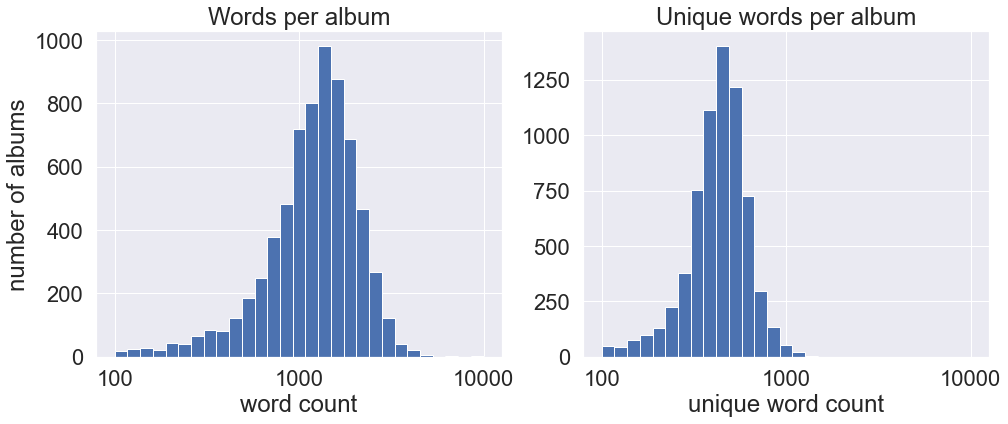

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

df_r_albums['word_count'].hist(bins=np.logspace(2, 4, 30), ax=ax1)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter())
ax1.set_xlabel("word count")
ax1.set_ylabel("number of albums")
ax1.set_title("Words per album")

df_r_albums['unique_word_count'].hist(bins=np.logspace(2, 4, 30), ax=ax2)
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.set_xlabel("unique word count")
ax2.set_title("Unique words per album")

plt.show()

In [37]:
album_cols_show = [c for c in df_r_albums.columns if c != 'words']

### Albums with highest word counts

In [70]:
df_r_albums.sort_values('word_count', ascending=False).reset_index().shift(1).loc[1:10, album_cols_show].convert_dtypes()

,band,album,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Blind Guardian,Twilight Orchestra: Legacy of the Dark Lands,"Speed Metal (early), Power Metal (later)",8210,8812,1010,1.07,0.12
2,Bal-Sagoth,The Chthonic Chronicles,Symphonic/Epic Black Metal,3639,6979,2073,1.92,0.57
3,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,3157,6500,1634,2.06,0.52
4,Savatage,The Wake of Magellan,"Heavy/Power Metal, Progressive Metal/Rock",3218,5264,1033,1.64,0.32
5,Ayreon,The Human Equation,Progressive Metal/Rock,5950,4917,805,0.83,0.14
6,Therion,Beloved Antichrist,"Death Metal (early), Symphonic/Operatic Metal ...",9110,4859,1008,0.53,0.11
7,Trans-Siberian Orchestra,The Christmas Attic,Orchestral/Progressive Rock/Metal,4066,4794,847,1.18,0.21
8,Blind Guardian,A Night at the Opera,"Speed Metal (early), Power Metal (later)",4024,4630,879,1.15,0.22
9,Machine Head,Catharsis,"Groove/Thrash Metal, Nu-Metal",4457,4623,1131,1.04,0.25
10,Cage,Ancient Evil,Heavy/Power Metal,4477,4569,1204,1.02,0.27


### Albums with highest unique word counts

In [71]:
df_r_albums.sort_values('unique_word_count', ascending=False).reset_index().shift(1).loc[1:10, album_cols_show].convert_dtypes()

,band,album,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Bal-Sagoth,The Chthonic Chronicles,Symphonic/Epic Black Metal,3639,6979,2073,1.92,0.57
2,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,3157,6500,1634,2.06,0.52
3,Cradle of Filth,Midian,"Death Metal (early), Symphonic Black Metal (mi...",3217,3816,1471,1.19,0.46
4,Cradle of Filth,"Darkly, Darkly, Venus Aversa","Death Metal (early), Symphonic Black Metal (mi...",3462,4235,1444,1.22,0.42
5,Cradle of Filth,Godspeed on the Devil's Thunder,"Death Metal (early), Symphonic Black Metal (mi...",4275,3646,1382,0.85,0.32
6,Cradle of Filth,Damnation and a Day,"Death Metal (early), Symphonic Black Metal (mi...",3995,3836,1381,0.96,0.35
7,Cradle of Filth,The Manticore and Other Horrors,"Death Metal (early), Symphonic Black Metal (mi...",3416,3498,1359,1.02,0.4
8,The Agonist,Prisoners,Melodic Death Metal/Metalcore,3213,3223,1265,1.0,0.39
9,Dying Fetus,Wrong One to Fuck With,Brutal Death Metal/Grindcore,3239,2731,1264,0.84,0.39
10,Exhumed,Anatomy Is Destiny,Death Metal/Grindcore,2346,3296,1259,1.4,0.54


### Albums with highest word density

In [72]:
df_r_albums.sort_values('words_per_second', ascending=False).reset_index().shift(1).loc[1:10, album_cols_show].convert_dtypes()

,band,album,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,3157,6500,1634,2.06,0.52
2,Melvins,Prick,"Sludge Metal, Various",257,504,193,1.96,0.75
3,Bal-Sagoth,The Chthonic Chronicles,Symphonic/Epic Black Metal,3639,6979,2073,1.92,0.57
4,Municipal Waste,Waste 'Em All,Thrash Metal/Crossover,848,1615,630,1.9,0.74
5,Origin,Informis Infinitas Inhumanitas,Technical Brutal Death Metal,1712,3022,942,1.77,0.55
6,Archspire,Relentless Mutation,Technical Death Metal,1837,3158,984,1.72,0.54
7,Korpiklaani,Noita,Folk Metal,178,293,90,1.65,0.51
8,Savatage,The Wake of Magellan,"Heavy/Power Metal, Progressive Metal/Rock",3218,5264,1033,1.64,0.32
9,Municipal Waste,Hazardous Mutation,Thrash Metal/Crossover,1425,2246,840,1.58,0.59
10,Nekrogoblikon,Heavy Meta,Melodic Death/Folk Metal,2151,3376,780,1.57,0.36


### Albums with highest unique word density

In [73]:
df_r_albums.sort_values('unique_words_per_second', ascending=False).reset_index().shift(1).loc[1:10, album_cols_show].convert_dtypes()

,band,album,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Haggard,Tales of Ithiria,Progressive Death Metal (early); Classical/Orc...,240,299,195,1.25,0.81
2,Melvins,Prick,"Sludge Metal, Various",257,504,193,1.96,0.75
3,Municipal Waste,Waste 'Em All,Thrash Metal/Crossover,848,1615,630,1.9,0.74
4,Helrunar,Frostnacht,Pagan Black Metal,92,107,59,1.16,0.64
5,Absurd,Werwolfthron,"Black Metal/RAC, Pagan Black Metal",122,145,76,1.19,0.62
6,Despised Icon,Consumed by Your Poison,Deathcore,639,591,375,0.92,0.59
7,Municipal Waste,Hazardous Mutation,Thrash Metal/Crossover,1425,2246,840,1.58,0.59
8,Soilent Green,Confrontation,Sludge/Death Metal/Grindcore,1730,2511,1006,1.45,0.58
9,Archspire,The Lucid Collective,Technical Death Metal,1661,2495,961,1.5,0.58
10,Bal-Sagoth,The Chthonic Chronicles,Symphonic/Epic Black Metal,3639,6979,2073,1.92,0.57


# Word counts by band

Surprisingly, Bal-Sagoth's inflated lyric counts do not matter much when comparing entire bands, perhaps due to how short their discography is. The bands with the highest word counts typically have massive discographies, and are usually power metal or heavy metal bands. Again, thrash and grindcore bands with short songs comprise most of the highest words-per-second list.

In [74]:
df_r_bands = pd.concat([
    df_r_albums.groupby('band')['genre'].first(),
    df_r_albums.groupby('band')['words'].sum(),
    df_r_albums.groupby('band')['seconds'].sum(),
], axis=1)
df_r_bands['word_count'] = df_r_bands['words'].apply(len)
df_r_bands['unique_word_count'] = df_r_bands['words'].apply(lambda x: len(set(x)))
df_r_bands = get_words_per_second(df_r_bands)
df_r_bands = df_r_bands.reset_index()

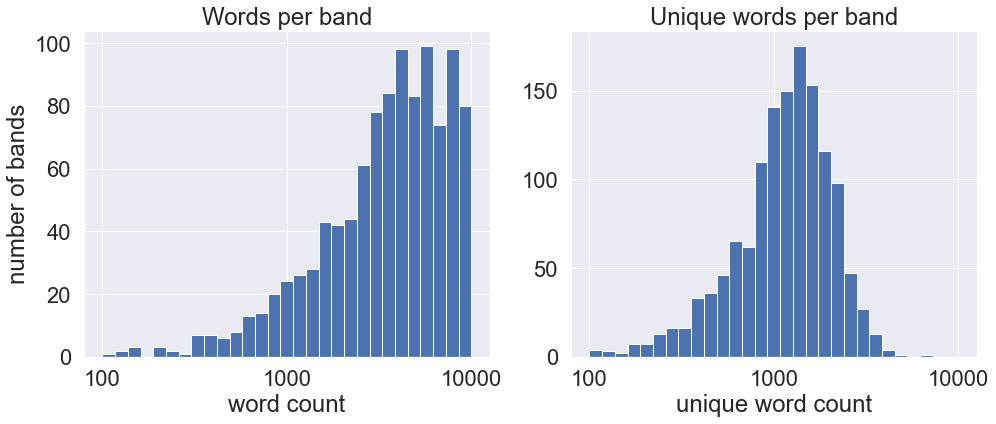

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

df_r_bands['word_count'].hist(bins=np.logspace(2, 4, 30), ax=ax1)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter())
ax1.set_xlabel("word count")
ax1.set_ylabel("number of bands")
ax1.set_title("Words per band")

df_r_bands['unique_word_count'].hist(bins=np.logspace(2, 4, 30), ax=ax2)
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.set_xlabel("unique word count")
ax2.set_title("Unique words per band")

plt.show()

In [76]:
band_cols_show = [c for c in df_r_bands.columns if c != 'words']

### Bands with highest word counts

In [77]:
df_r_bands.sort_values('word_count', ascending=False).reset_index().shift(1).loc[1:10, band_cols_show].convert_dtypes()

,band,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Cradle of Filth,"Death Metal (early), Symphonic Black Metal (mi...",44097,41815,6415,0.95,0.15
2,Saxon,"NWOBHM, Heavy Metal",53755,36759,2665,0.68,0.05
3,Iron Maiden,"Heavy Metal, NWOBHM",52673,34843,3241,0.66,0.06
4,Blind Guardian,"Speed Metal (early), Power Metal (later)",38090,34836,2416,0.91,0.06
5,Rage,Heavy/Speed/Power Metal,56064,34314,2874,0.61,0.05
6,Overkill,Thrash Metal; Thrash/Groove Metal,47540,32485,3119,0.68,0.07
7,Helloween,Power/Speed Metal,48991,32472,2769,0.66,0.06
8,Tankard,Thrash Metal,38493,30652,3710,0.8,0.1
9,Cannibal Corpse,Death Metal,32398,30596,4377,0.94,0.14
10,Judas Priest,Heavy Metal,51177,30143,3506,0.59,0.07


### Bands with highest unique word counts

In [79]:
df_r_bands.sort_values('unique_word_count', ascending=False).reset_index().shift(1).loc[1:10, band_cols_show].convert_dtypes()

,band,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Cradle of Filth,"Death Metal (early), Symphonic Black Metal (mi...",44097,41815,6415,0.95,0.15
2,Napalm Death,"Hardcore Punk (early), Grindcore/Death Metal (...",34363,20338,4833,0.59,0.14
3,Cannibal Corpse,Death Metal,32398,30596,4377,0.94,0.14
4,Skyclad,Folk Metal,25903,26651,4179,1.03,0.16
5,The Black Dahlia Murder,Melodic Death Metal,17441,20061,3945,1.15,0.23
6,Dying Fetus,Brutal Death Metal/Grindcore,16783,15110,3930,0.9,0.23
7,Sodom,"Black/Speed Metal (early), Thrash Metal (later)",34897,26202,3741,0.75,0.11
8,Bal-Sagoth,Symphonic/Epic Black Metal,16021,21458,3730,1.34,0.23
9,Tankard,Thrash Metal,38493,30652,3710,0.8,0.1
10,Judas Priest,Heavy Metal,51177,30143,3506,0.59,0.07


### Bands with highest word density

In [80]:
df_r_bands.sort_values('words_per_second', ascending=False).reset_index().shift(1).loc[1:10, band_cols_show].convert_dtypes()

,band,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Archspire,Technical Death Metal,5189,7454,1970,1.44,0.38
2,Municipal Waste,Thrash Metal/Crossover,7479,10587,2167,1.42,0.29
3,Blood Freak,Death Metal/Grindcore,4447,6123,1778,1.38,0.4
4,Acrania,Brutal Deathcore,1674,2282,902,1.36,0.54
5,Bal-Sagoth,Symphonic/Epic Black Metal,16021,21458,3730,1.34,0.23
6,The Berzerker,Industrial Death Metal/Grindcore,8290,10562,1383,1.27,0.17
7,Animosity,Death Metal/Metalcore/Grindcore,4677,5795,1302,1.24,0.28
8,Absurd,"Black Metal/RAC, Pagan Black Metal",122,145,76,1.19,0.62
9,The Black Dahlia Murder,Melodic Death Metal,17441,20061,3945,1.15,0.23
10,Exhumed,Death Metal/Grindcore,13765,15669,3492,1.14,0.25


### Bands with highest unique word density

In [81]:
df_r_bands.sort_values('unique_words_per_second', ascending=False).reset_index().shift(1).loc[1:10, band_cols_show].convert_dtypes()

,band,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Absurd,"Black Metal/RAC, Pagan Black Metal",122,145,76,1.19,0.62
2,Acrania,Brutal Deathcore,1674,2282,902,1.36,0.54
3,The County Medical Examiners,Goregrind,1794,1662,932,0.93,0.52
4,Peste Noire,Black Metal,389,345,186,0.89,0.48
5,Regurgitate,Goregrind,739,575,349,0.78,0.47
6,Glittertind,Viking/Folk Metal (early); Indie/Folk Rock (la...,394,413,173,1.05,0.44
7,Insect Warfare,Grindcore,1253,1233,539,0.98,0.43
8,Intestinal Disgorge,"Noise/Grindcore (early), Brutal Death Metal/No...",1493,1628,616,1.09,0.41
9,Blood Freak,Death Metal/Grindcore,4447,6123,1778,1.38,0.4
10,Archspire,Technical Death Metal,5189,7454,1970,1.44,0.38


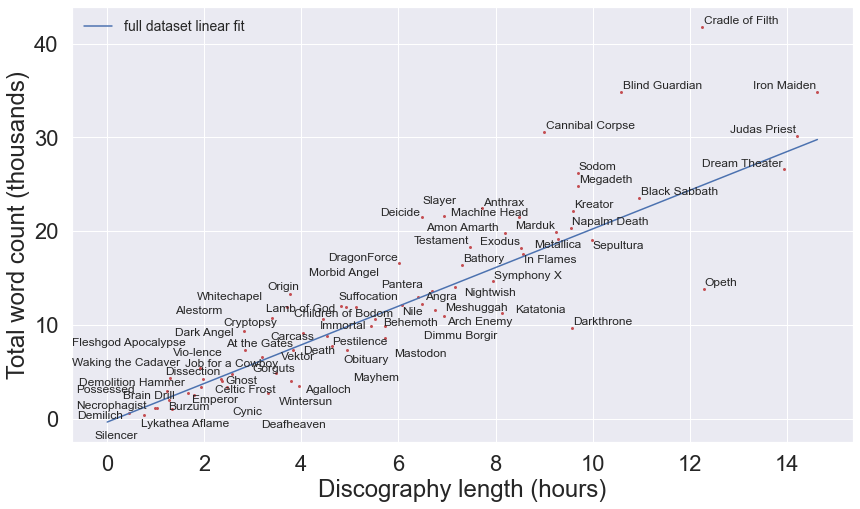

In [ ]:
min_reviews = 20

bands_popular = sorted(set(df_r[df_r['album_review_num'] > min_reviews].band_name))
df_r_bands_popular = df_r_bands[df_r_bands.band_name.isin(bands_popular)].set_index('band_name', drop=True)

plt.figure(figsize=(14, 8))
xlist, ylist = [], []
for band, row in df_r_bands_popular.iterrows():
    x = row['band_seconds'] / 3600.0
    y = row['band_word_count'] / 1000.0
    xlist.append(x)
    ylist.append(y)
    plt.plot(x, y, 'r.')

res = linregress(df_r_bands.band_seconds / 3600.0, df_r_bands.band_word_count / 1000.0)
xline = np.linspace(0, df_r_bands_popular.band_seconds.max() / 3600.0)
yline = xline * res.slope + res.intercept
plt.plot(xline, yline, label='full dataset linear fit')

texts = []
for x, y, band in zip(xlist, ylist, df_r_bands_popular.index):
    texts.append(plt.text(x, y, band, fontsize=12))
adjust_text(texts)

plt.xlabel('Discography length (hours)')
plt.ylabel('Total word count (thousands)')
plt.legend(fontsize=14)
plt.show()

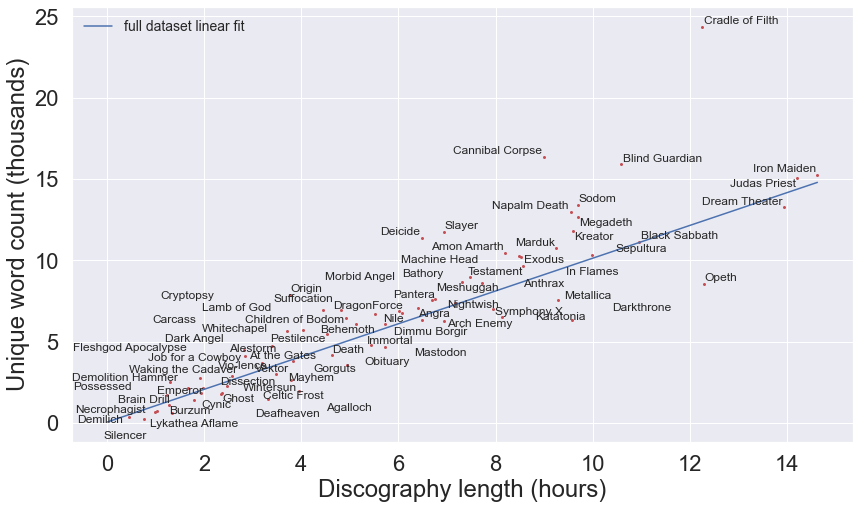

In [16]:
plt.figure(figsize=(14, 8))
xlist, ylist = [], []
for band, row in df_r_bands_popular.iterrows():
    x = row['band_seconds'] / 3600.0
    y = row['band_unique_word_count'] / 1000.0
    xlist.append(x)
    ylist.append(y)
    plt.plot(x, y, 'r.')

res = linregress(df_r_bands.band_seconds / 3600.0, df_r_bands.band_unique_word_count / 1000.0)
xline = np.linspace(0, df_r_bands_popular.band_seconds.max() / 3600.0)
yline = xline * res.slope + res.intercept
plt.plot(xline, yline, label='full dataset linear fit')

texts = []
for x, y, band in zip(xlist, ylist, df_r_bands_popular.index):
    texts.append(plt.text(x, y, band, fontsize=12))
adjust_text(texts)

plt.xlabel('Discography length (hours)')
plt.ylabel('Unique word count (thousands)')
plt.legend(fontsize=14)
plt.show()

In [90]:
,"""Copied from https://stackoverflow.com/questions/55005272/get-bounding-boxes-of-individual-elements-of-a-pathcollection-from-plt-scatter
"""

from matplotlib.path import get_path_collection_extents

def getbb(sc, ax):
    """ Function to return a list of bounding boxes in data coordinates
        for a scatter plot """
    ax.figure.canvas.draw() # need to draw before the transforms are set.
    transform = sc.get_transform()
    transOffset = sc.get_offset_transform()
    offsets = sc._offsets
    paths = sc.get_paths()
    transforms = sc.get_transforms()

    if not transform.is_affine:
        paths = [transform.transform_path_non_affine(p) for p in paths]
        transform = transform.get_affine()
    if not transOffset.is_affine:
        offsets = transOffset.transform_non_affine(offsets)
        transOffset = transOffset.get_affine()

    if isinstance(offsets, np.ma.MaskedArray):
        offsets = offsets.filled(np.nan)

    bboxes = []

    if len(paths) and len(offsets):
        if len(paths) < len(offsets):
            # for usual scatters you have one path, but several offsets
            paths = [paths[0]]*len(offsets)
        if len(transforms) < len(offsets):
            # often you may have a single scatter size, but several offsets
            transforms = [transforms[0]]*len(offsets)

        for p, o, t in zip(paths, offsets, transforms):
            result = get_path_collection_extents(
                transform.frozen(), [p], [t],
                [o], transOffset.frozen())
            bboxes.append(result.transformed(ax.transData.inverted()))

    return bboxes

In [91]:
def plot_swarm(data, names):
    fig = plt.figure(figsize=(25, 12), facecolor='black')
    ax = sns.swarmplot(x=data, size=50, zorder=1)

    # Get bounding boxes of scatter points
    cs = ax.collections[0]
    boxes = getbb(cs, ax)

    # Add text to circles
    for i, box in enumerate(boxes):
        x = box.x0 + box.width / 2
        y = box.y0 + box.height / 2
        s = names.iloc[i].replace(' ', '\n')
        txt = ax.text(x, y, s, color='white', va='center', ha='center')

        # Shrink font size until text fits completely in circle
        for fs in range(10, 1, -1):
            txt.set_fontsize(fs)
            tbox = txt.get_window_extent().transformed(ax.transData.inverted())
            if (
                    abs(tbox.width) < np.cos(0.5) * abs(box.width)
                    and abs(tbox.height) < np.cos(0.5) * abs(box.height)
            ):
                break

    ax.xaxis.tick_top()
    ax.set_xlabel('')
    ax.tick_params(axis='both', colors='white')

    return fig

In [92]:
band_words = pd.concat(
    (
        df_r.groupby('band_id')['band_name'].first(),
        df_r.groupby(['band_id', 'album_name'])['album_review_num'].first().groupby('band_id').sum(),
        df_r.groupby('band_id')['song_words'].sum()
    ),
    axis=1
)
band_words.columns = ['name', 'reviews', 'words']

In [93]:
band_words.sort_values('reviews')[-200:]

,name,reviews,words
band_id,,,
53941,Enforcer,46,"[looking, out, into, the, silent, night, and, ..."
4844,Isis,46,"[remit, remit, the, signal, the, flood, is, co..."
7477,Municipal Waste,46,"[unsuspecting, victims, with, no, chance, to, ..."
162,Sentenced,46,"[wasted, left, behind, as, an, old, man, nears..."
1815,Norther,47,"[once, there, was, a, time, darker, than, the,..."
...,...,...,...
146,Darkthrone,274,"[into, the, abyss, i, fall, and, dark, is, the..."
97,Judas Priest,297,"[where, would, you, be, without, music, you, w..."
99,Black Sabbath,330,"[what, is, this, that, stands, before, me, fig..."


100


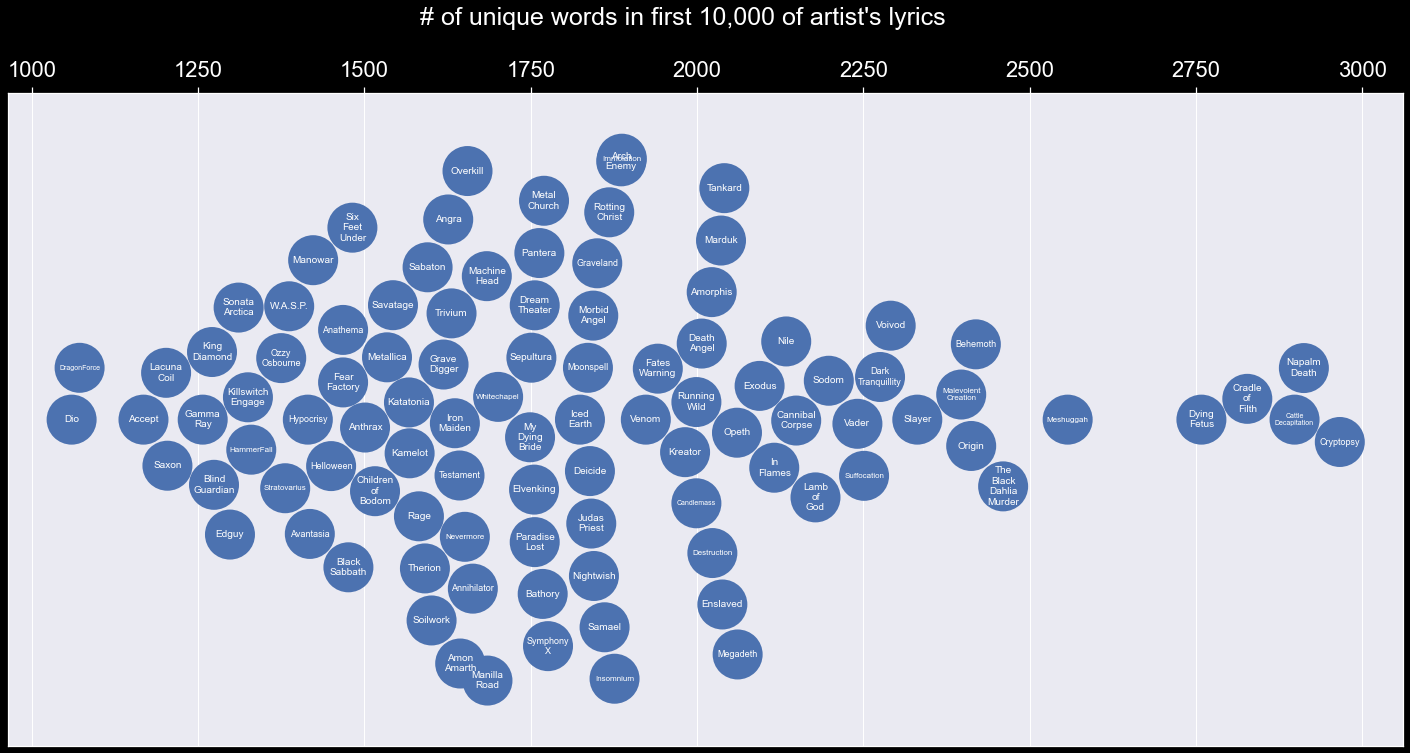

In [115]:
num_bands = 100
num_words = 10000

band_filt_words = band_words[band_words['words'].apply(len) >= num_words].sort_values('reviews')[-num_bands:]
band_filt_words['unique_first_words'] = band_filt_words['words'].apply(lambda x: len(set(x[:num_words])))
band_filt_words = band_filt_words.sort_values('unique_first_words')
print(len(band_filt_words))

fig = plot_swarm(band_filt_words['unique_first_words'], band_filt_words['name'])
fig.suptitle(f"# of unique words in first {num_words:,.0f} of artist's lyrics", color='white', fontsize=25)
plt.show()

150


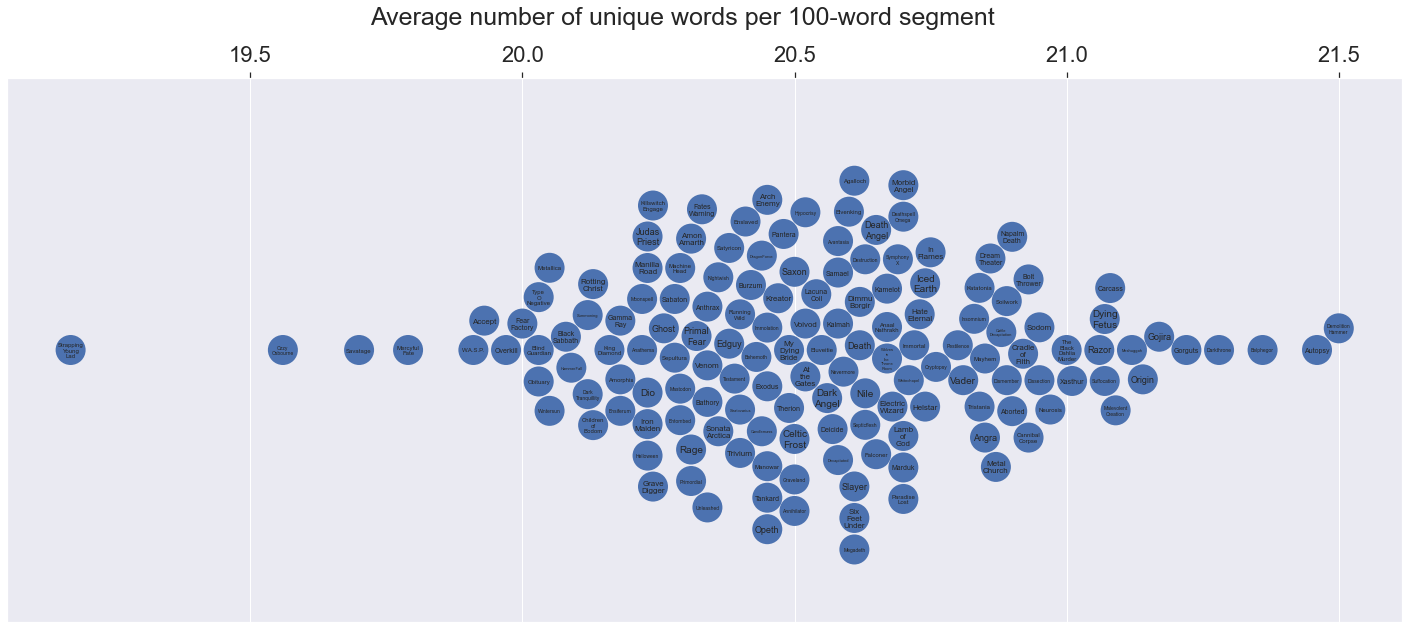

In [8]:
def avg_unique_words(x, n_iter=100, seglen=100):
    counts = np.zeros(n_iter)
    idices = range(len(x) - seglen)
    for i in range(n_iter):
        k = np.random.choice(idices)
        seg = x[k: k + seglen]
        counts[i] = len(set(seg))
    out = counts.mean()
    return out

# min_reviews = 50
# num_words = 1000

# band_filt_words = band_words[(band_words['reviews'] > min_reviews) & (band_words['words'].apply(len) > num_words)].copy()

num_bands = 150
band_filt_words = band_words.loc[band_words.sort_values('reviews')['name'][-num_bands:].index]
print(len(band_filt_words))

band_filt_words['avg_unique_words'] = band_filt_words['words'].apply(avg_unique_words)
band_filt_words = band_filt_words.sort_values('avg_unique_words')

fig = plot_swarm(band_filt_words['avg_unique_words'], band_filt_words['name'])
fig.suptitle('Average number of unique words per 100-word segment', fontsize=25)
plt.show()

C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 91.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


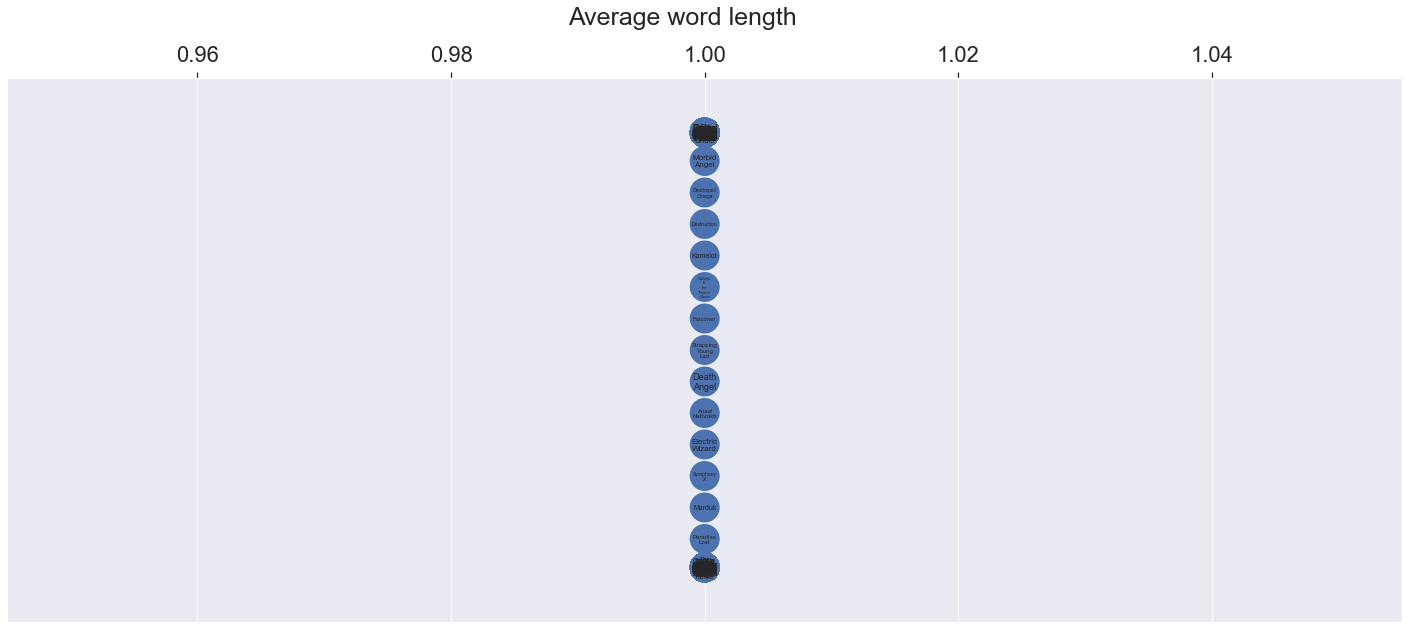

In [9]:
band_filt_words['avg_word_len'] = band_filt_words['words'].apply(lambda x: np.mean(list(map(len, x))))
band_filt_words = band_filt_words.sort_values('avg_word_len')

fig = plot_swarm(band_filt_words['avg_word_len'], band_filt_words['name'])
fig.suptitle('Average word length', fontsize=25)
plt.show()

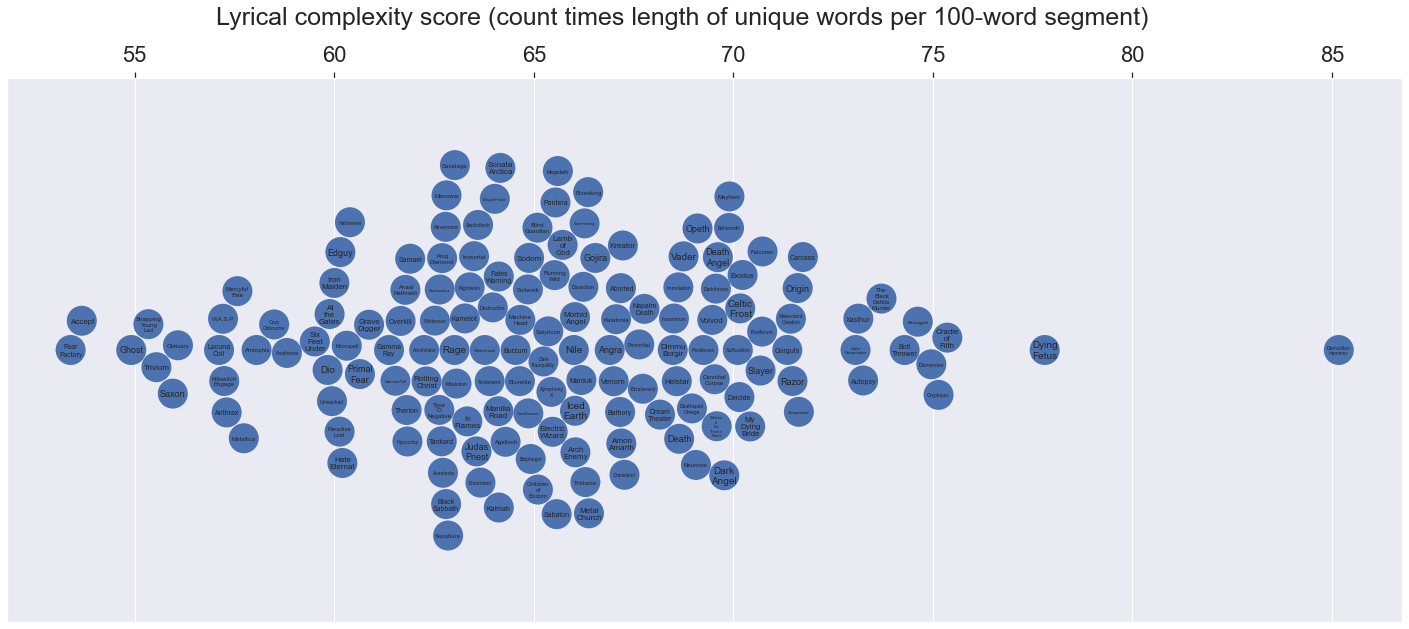

In [435]:
def avg_unique_words_len_weighted(x, n_iter=100, seglen=100):
    counts = np.zeros(n_iter)
    idices = range(len(x) - seglen)
    for i in range(n_iter):
        k = np.random.choice(idices)
        seg = x[k: k + seglen]
        uniq = set(seg)
        avg_len = np.mean(list(map(len, uniq)))
        counts[i] = len(uniq) * avg_len
    out = counts.mean()
    return out

band_filt_words['avg_unique_words_len_weighted'] = band_filt_words['words'].apply(avg_unique_words)
band_filt_words = band_filt_words.sort_values('avg_unique_words_len_weighted')

fig = plot_swarm(band_filt_words['avg_unique_words_len_weighted'], band_filt_words['name'])
fig.suptitle('Lyrical complexity score (count times length of unique words per 100-word segment)', fontsize=25)
plt.show()

# Word counts by genre

Although there are some noticeable trends in the word counts of genres, overall the distributions of word counts and song lengths per genre are quite broad, perhaps overlapping too much to be of any use for predictions later on.

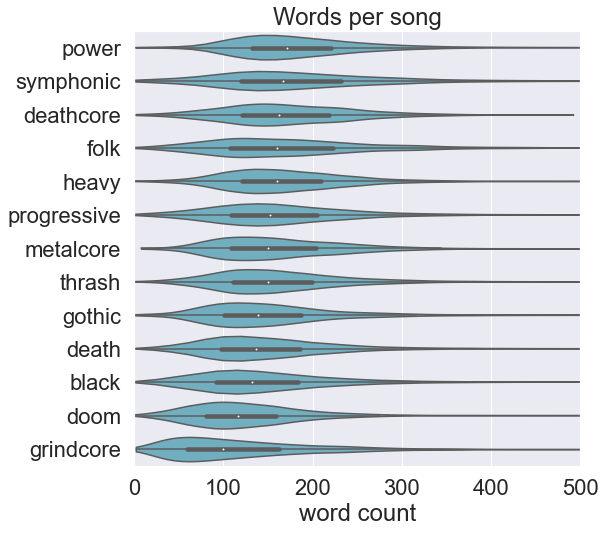

In [19]:
df_genre_songs = df_r[['band_name', 'album_name', 'song_name'] + [f"genre_{genre}" for genre in top_genres_1pct]].copy()
df_genre_songs['song_word_count'] = df_r_songs.song_word_count
df_genre_songs['song_seconds'] = df_r_songs.song_seconds

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
violindata = []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs['genre_' + genre] == 1]
    violindata.append((genre, df_genre['song_word_count']))
violindata.sort(key=lambda x: -np.median(x[1]))
sns.violinplot(data=[x[1] for x in violindata], cut=0, orient='h', color='c')
ax.set_yticklabels([x[0] for x in violindata])
ax.set_xlim(0, 500)
ax.set_title("Words per song")
ax.set_xlabel("word count")
plt.show()

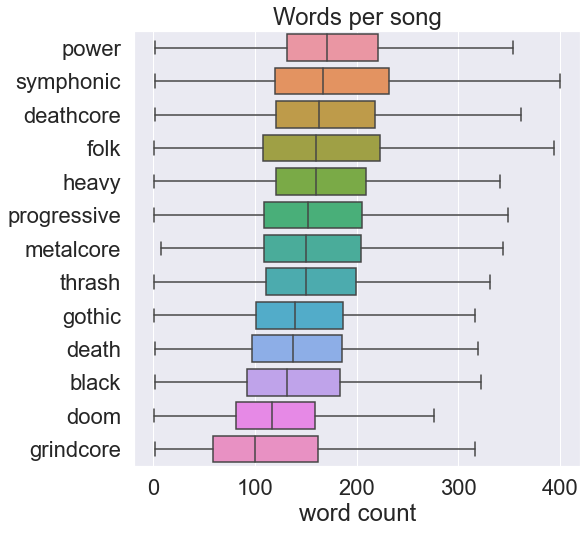

In [40]:
df_genre_songs = df_r[['band_name', 'album_name', 'song_name'] + [f"genre_{genre}" for genre in top_genres_1pct]].copy()
df_genre_songs['song_word_count'] = df_r_songs.song_word_count
df_genre_songs['song_seconds'] = df_r_songs.song_seconds

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
violindata = []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs['genre_' + genre] == 1]
    violindata.append((genre, df_genre['song_word_count'].values))
violindata.sort(key=lambda x: -np.median(x[1]))
sns.boxplot(data=[x[1] for x in violindata], orient='h', showfliers=False)
ax.set_yticklabels([x[0] for x in violindata])
ax.set_xlim
# ax.set_xlim(0, 500)
ax.set_title("Words per song")
ax.set_xlabel("word count")
plt.show()

In [39]:
np.percentile(violindata[0][1], 75)

221.0

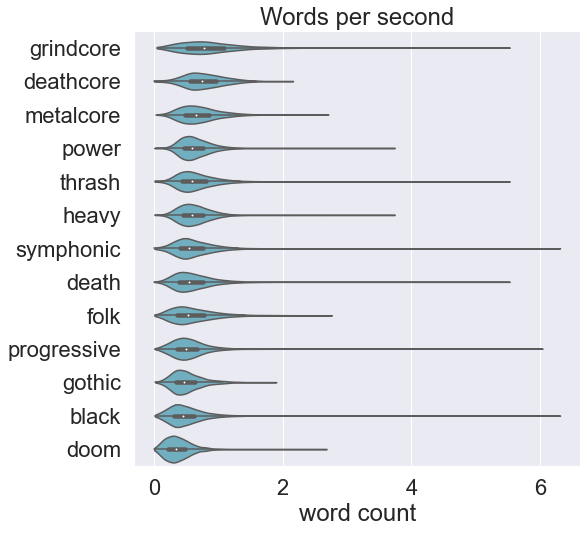

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
violindata = []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs['genre_' + genre] == 1].copy()
    df_genre['song_words_per_second'] = df_genre['song_word_count'] / df_genre['song_seconds']
    df_genre.loc[df_genre['song_words_per_second'] == np.inf, 'song_words_per_second'] = 0
    violindata.append((genre, df_genre['song_words_per_second']))
violindata.sort(key=lambda x: -np.median(x[1]))
sns.violinplot(data=[x[1] for x in violindata], cut=0, orient='h', color='c')
ax.set_yticklabels([x[0] for x in violindata])
ax.set_title("Words per second")
ax.set_xlabel("word count")
plt.show()

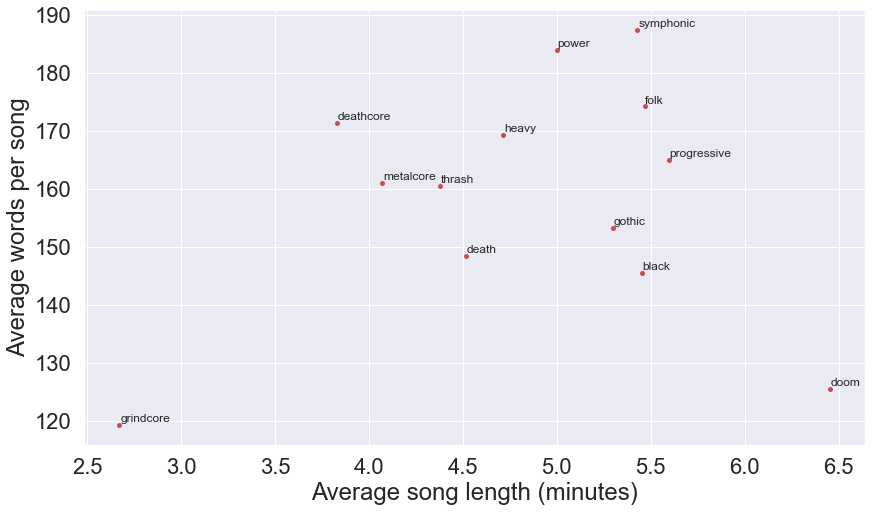

In [30]:
plt.figure(figsize=(14, 8))
xlist, ylist = [], []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs['genre_' + genre] == 1].copy()
    x = df_genre['song_seconds'].mean() / 60.0
    y = df_genre['song_word_count'].mean()
    xlist.append(x)
    ylist.append(y)
    plt.plot(x, y, 'r.', ms=10, label=genre)
texts = []
for x, y, genre in zip(xlist, ylist, top_genres_1pct):
    texts.append(plt.text(x, y , genre, fontsize=12))
adjust_text(texts)
plt.xlabel('Average song length (minutes)')
plt.ylabel('Average words per song')
plt.show()

### 95% contours for top-five genres

In [31]:
df_genre_10pct_songs = df_rr[['band_name', 'album_name', 'song_name'] + [f"genre_{genre}" for genre in top_genres_10pct]].copy()
df_genre_10pct_songs['song_word_count'] = df_rr.song_words.apply(len)
df_genre_10pct_songs['song_seconds'] = to_seconds(df_rr)

C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


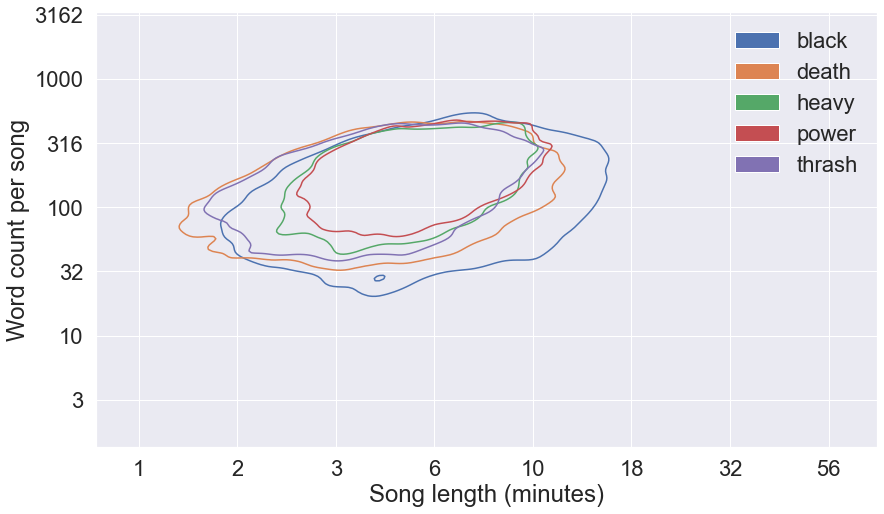

In [32]:
plt.figure(figsize=(14, 8))
ax = plt.gca()
colors = sns.color_palette()
handles = []
for i, genre in enumerate(top_genres_10pct):
    df_genre = df_genre_10pct_songs[df_genre_10pct_songs['genre_' + genre] == 1].copy()
    x = np.log10(df_genre['song_seconds'] / 60.0)
    y = np.log10(df_genre['song_word_count'])
    pos = (x > 0) & (y > 0)
    sns.kdeplot(x=x[pos], y=y[pos], levels=[0.05, 1], ax=ax)
    handles.append(Patch(facecolor=colors[i % len(colors)], label=genre))
ax.set_xticklabels([f"{10**tick:.0f}" for tick in ax.get_xticks()])
ax.set_yticklabels([f"{10**tick:.0f}" for tick in ax.get_yticks()])
ax.set_xlabel('Song length (minutes)')
ax.set_ylabel('Word count per song')
ax.legend(handles=handles)
plt.show()